In [32]:
import os
import pandas as pd
from pylab import *

In [5]:
ny_file.seek(0,2)

2482634728

In [6]:
ny_file.tell()

2482634728

In [14]:
# Read Module
os.chdir('/Users/Ra/Desktop/on_semi_ds/data/RawData/')
trans_columns = ["id","Year","Customer Segment","Channel","CustomerID","Order No","Orders","Sales","SKU No","Supplier","Order Date","Month"]
trans_df = pd.DataFrame(columns = trans_columns)
my_file = open('Trans.csv')

i = 0
local_cntr = 0
for line in my_file:
    if i == 10000:
        break
    if i != 0:
        line = line.replace('"', '')
        l = line.split(',')
        trans_df.loc[i] = l
    i += 1

In [17]:
'''
Module to perform analysis on PHILLIPSL
Steps-
1. Create a small dataset for PHILLIPS supplier, 
    the entire dataset is too big, so for analysis
    puropose I decided to create a datframe with small
    chunk pf data.
2. Check trends of customers to identify churn.
'''

# Create interim datafrme to store non phillips data.
trans_no_phl_df = pd.DataFrame(columns = trans_columns)
# Create interim datafrme to store only phillips data.
trans_ph_df = pd.DataFrame(columns = trans_columns)

for i in range(1, len(trans_df)):
    if trans_df['Supplier'][i] == 'PHILIPSLa':
        trans_ph_df.loc[i] = trans_df.loc[i]
    else:
        trans_no_phl_df.loc[i] = trans_df.loc[i]

# sort the data based on year.
trans_ph_df = trans_ph_df.sort_values('Year')

# Remove na values and reindex.
trans_ph_df.dropna(inplace = True)
trans_ph_df.reset_index(drop = True, inplace = True)

trans_no_phl_df.dropna(inplace = True)
trans_no_phl_df.reset_index(drop = True, inplace = True)

# store the sku no of items supplied by phillips.
items_phillips = set()
for items in trans_ph_df['SKU No']:
    items_phillips.add(items)

# Create an interim df with items supplied by phillips.
similar_items_df = pd.DataFrame(index = trans_no_phl_df.index, columns = trans_columns)
for i in range(0, len(trans_no_phl_df)):
    if trans_no_phl_df['SKU No'][i] in items_phillips:
        similar_items_df.loc[i] = trans_no_phl_df.loc[i]
similar_items_df.dropna(inplace = True)
similar_items_df.reset_index(drop = True, inplace = True)

# Data Wrangling and cleaning
# sort the data based on year
similar_items_df = similar_items_df.sort_values('Year')
similar_items_df['total_amt'] = 0

for i in range(1, len(similar_items_df)):
    # Convert month value to integer.
    similar_items_df['Month'][i] = int(similar_items_df['Month'][i])
    # Create total amount column by multiplying per unit cost.
    # with toatl orders.
    similar_items_df['total_amt'][i] = int(similar_items_df['Orders'][i]) * float(similar_items_df['Sales'][i])

# Create new aggegate dataframe with pertinent columns.
#cust_target_agg_df = pd.DataFrame(columns = ['Year', 'id', 'amount'])
cust_target_agg_df = similar_items_df.groupby(['Year', 'CustomerID', 'Supplier', 'SKU No']).total_amt.sum().to_frame('Total_Sale').reset_index()

# add composite key- concat(CustomerID, Supplier)
cust_target_agg_df['c_key'] = 'N/A'
for i in range(0, len(cust_target_agg_df)):
    cust_target_agg_df['c_key'][i] = cust_target_agg_df['CustomerID'][i] + cust_target_agg_df['Supplier'][i]
    
# creating the tagged dataframe
cust_target_tagged_df = pd.DataFrame(index=cust_target_agg_df.index, columns = ['customer_id', 'c_key', 'median', 'curr_year_percentage', 'tag'])
cust_target_tagged_df['tag'] = 'No Value'
idx = 0
for customers in cust_target_agg_df['CustomerID']:
    curr_year = 0
    percentage = []
    init_store = []
    for i in range(0, len(cust_target_agg_df)):
        if cust_target_agg_df['CustomerID'][i] == customers:
            init_store.append(cust_target_agg_df['Total_Sale'][i])
            cust_target_tagged_df['c_key'][i] = cust_target_agg_df['c_key'][i]
    
    # Calculate percentage increase or decrease.
    for i in range(1, len(init_store)):
        temp = ((init_store[i] - init_store[i - 1]) / init_store[i - 1]) * 100
        percentage.append(temp)
    
    ln = len(percentage) - 1
    if ln >= 0:
        curr_year = percentage[ln]
    # Drop the na values and reset index
    cust_target_tagged_df.dropna(subset=['c_key'], inplace = True)
    cust_target_tagged_df.reset_index(drop = True, inplace = True)
    # Calculate the kpi metrices.
    cust_target_tagged_df['customer_id'][idx] = customers
    cust_target_tagged_df['median'][idx] = median(percentage)
    cust_target_tagged_df['curr_year_percentage'][idx] = curr_year
    idx += 1
print(cust_target_tagged_df)
# Tag the customer ids based on anlysis
for i in range(0, len(cust_target_tagged_df)):
    if cust_target_tagged_df['median'][i] > 0 and cust_target_tagged_df['curr_year_percentage'][i] < 0:
        cust_target_tagged_df['tag'][i] = 'high focus'
    elif cust_target_tagged_df['median'][i] > 0 and cust_target_tagged_df['curr_year_percentage'][i] > 0 and cust_target_tagged_df['curr_year_percentage'][i] < cust_target_tagged_df['median'][i]:
        cust_target_tagged_df['tag'][i] = 'medium focus'
    elif cust_target_tagged_df['median'][i] < 0 and cust_target_tagged_df['curr_year_percentage'][i] > 0 and cust_target_tagged_df['curr_year_percentage'][i] > cust_target_tagged_df['median'][i]:
        cust_target_tagged_df['tag'][i] = 'keep track'
    else:
        cust_target_tagged_df['tag'][i] = 'safe'

cust_target_tagged_df

Empty DataFrame
Columns: [customer_id, c_key, median, curr_year_percentage, tag]
Index: []


--------------------------------------------
Plotting for segment-
J
--------------------------------------------


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


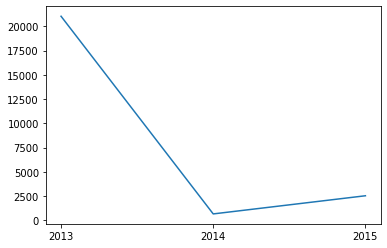

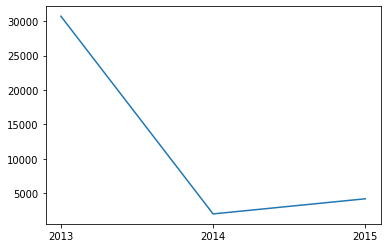

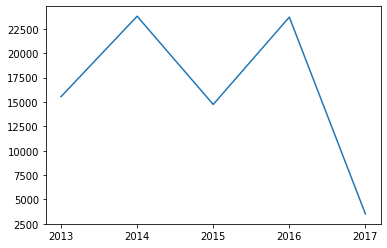

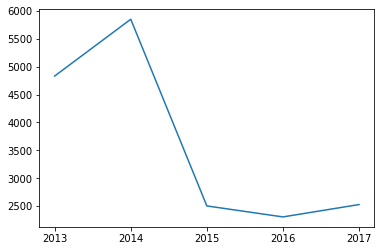

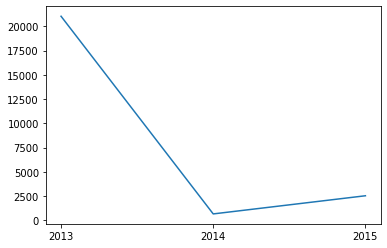

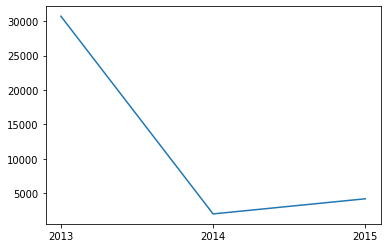

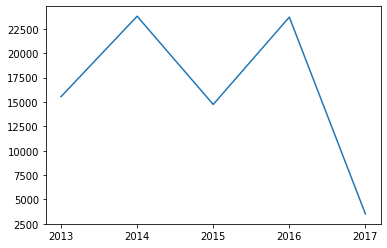

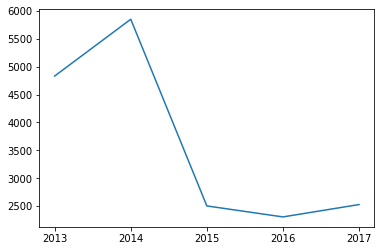

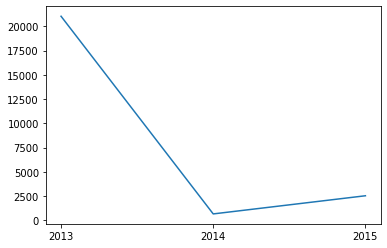

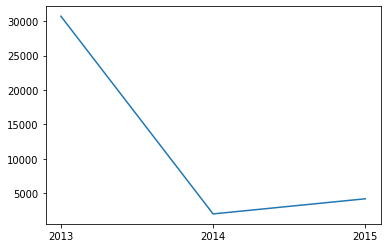

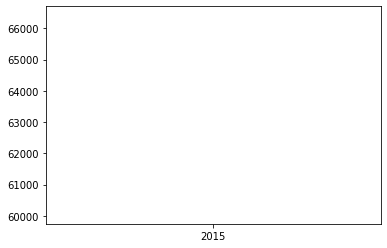

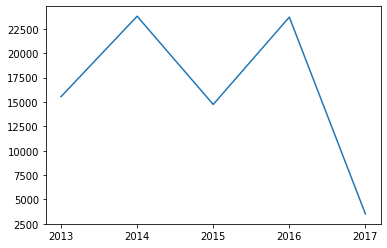

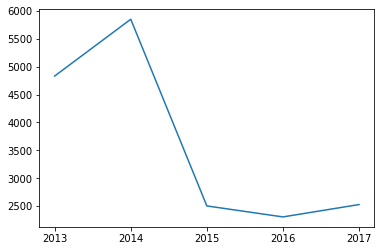

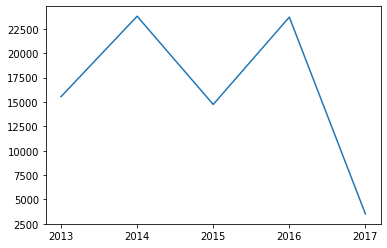

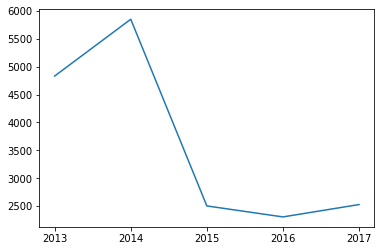

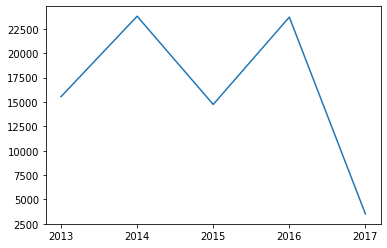

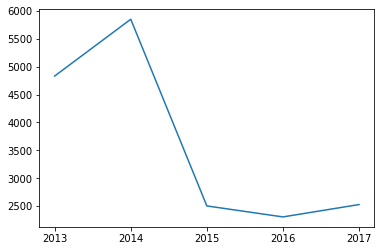

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


--------------------------------------------
Plotting for segment-
N
--------------------------------------------


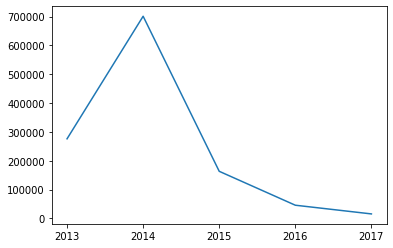

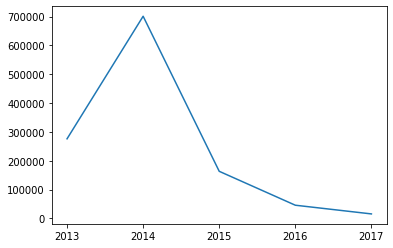

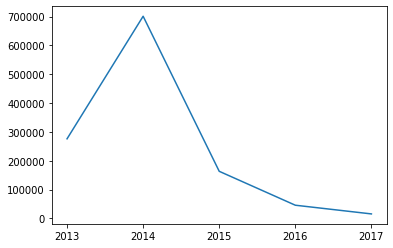

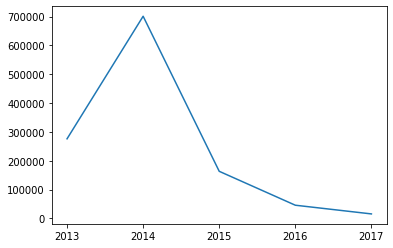

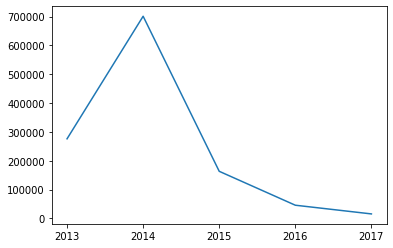

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


--------------------------------------------
Plotting for segment-
K
--------------------------------------------


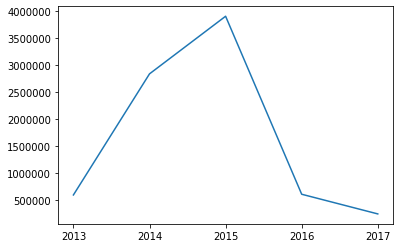

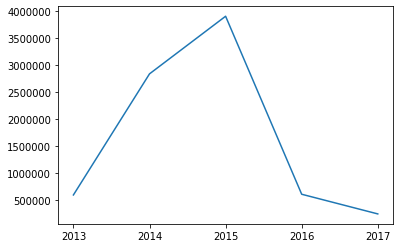

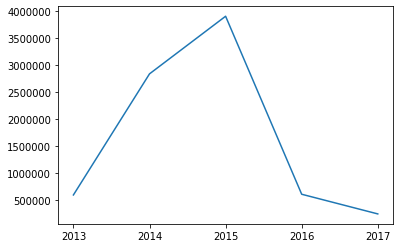

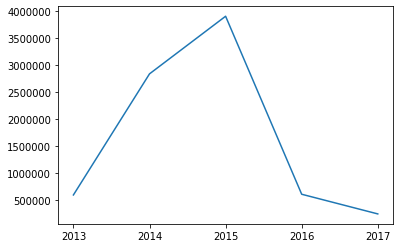

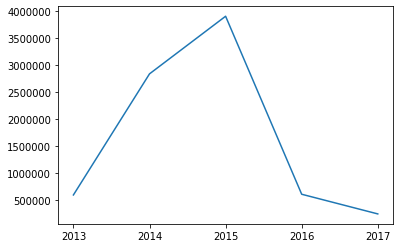

--------------------------------------------
Plotting for segment-
U
--------------------------------------------


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


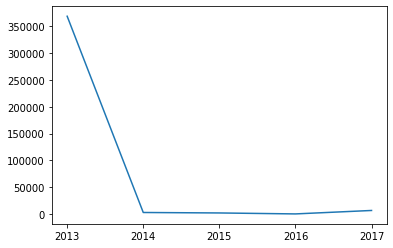

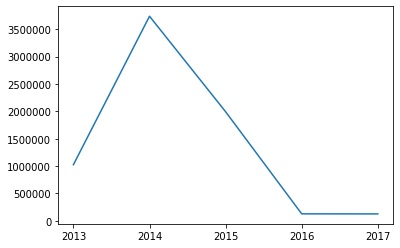

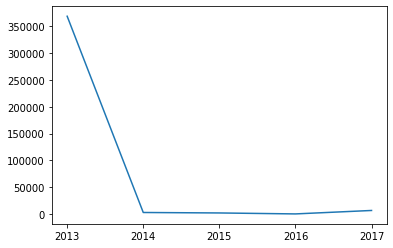

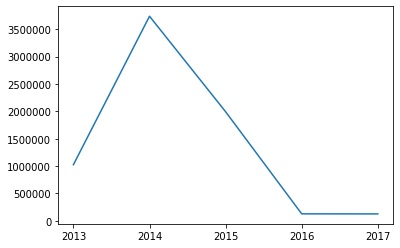

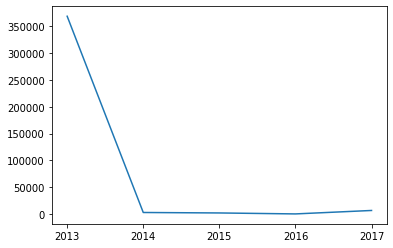

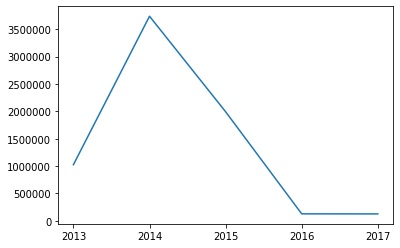

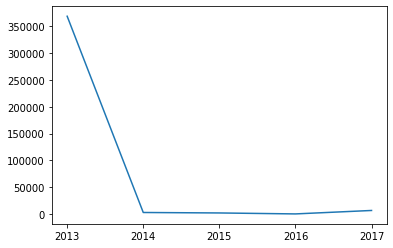

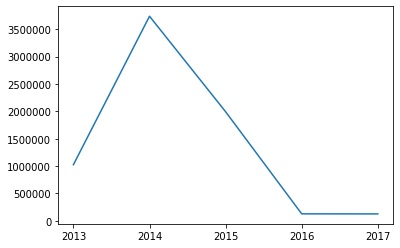

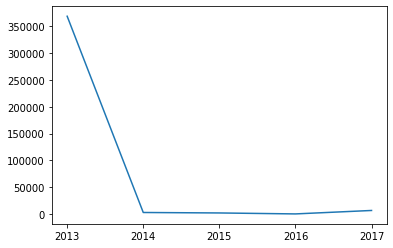

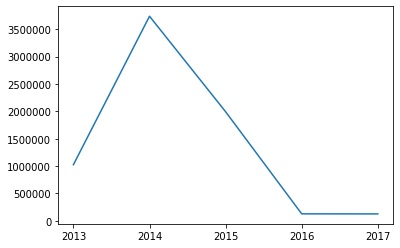

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


--------------------------------------------
Plotting for segment-
I
--------------------------------------------


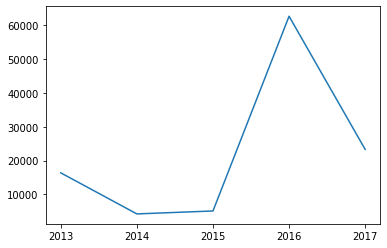

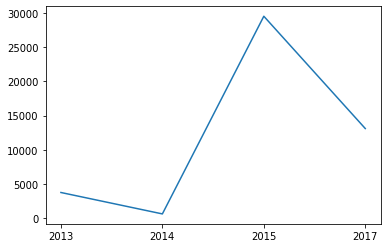

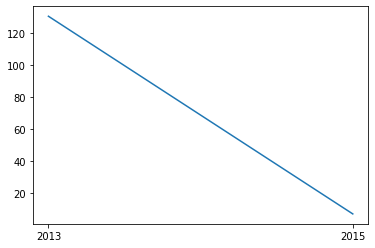

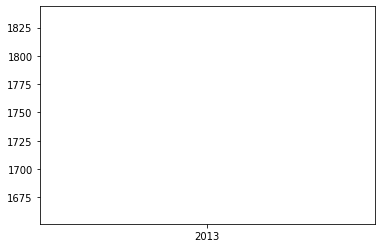

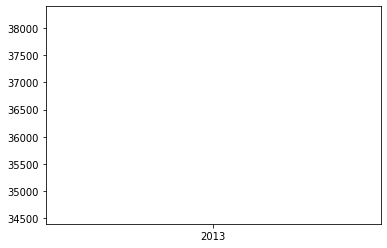

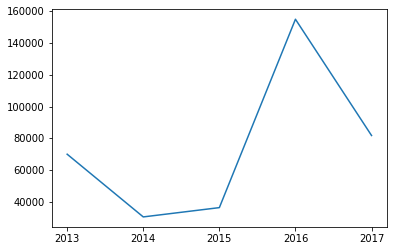

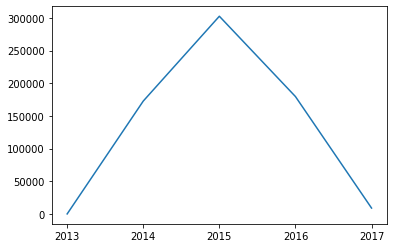

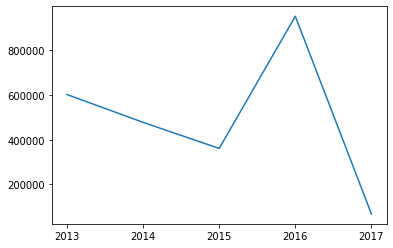

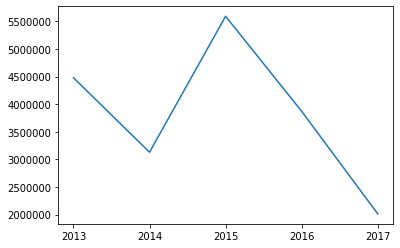

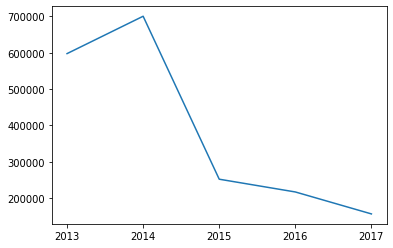

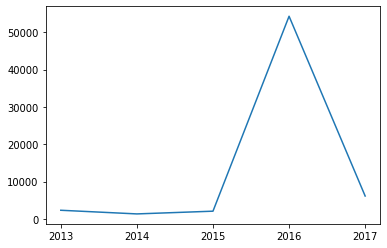

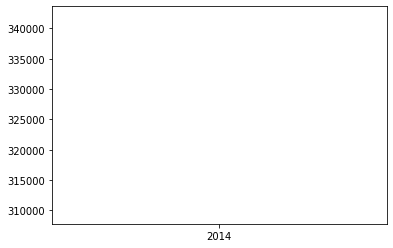

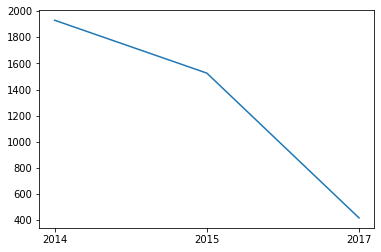

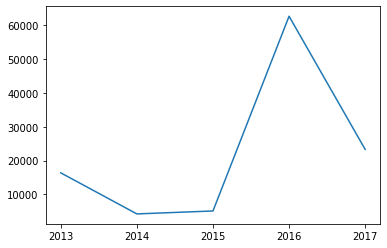

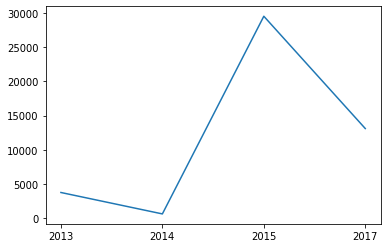

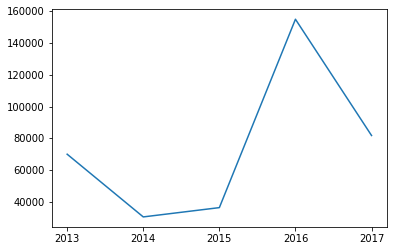

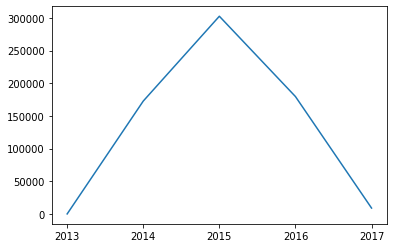

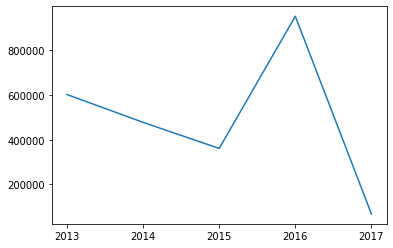

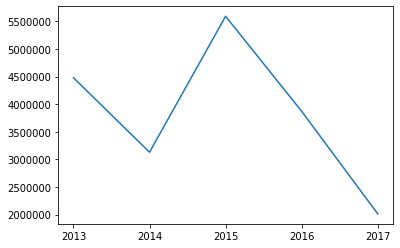

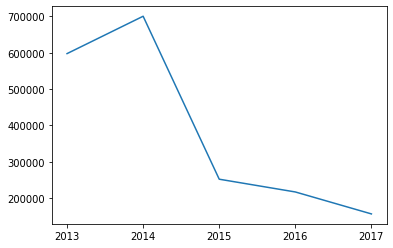

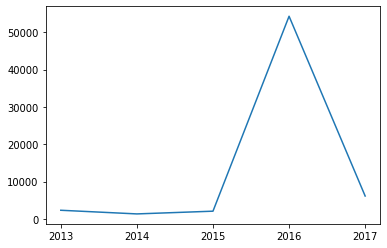

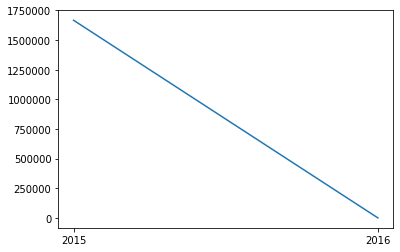

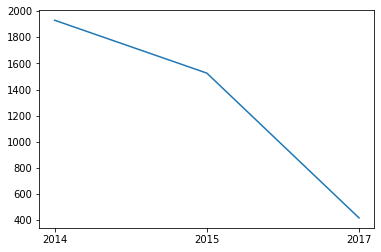

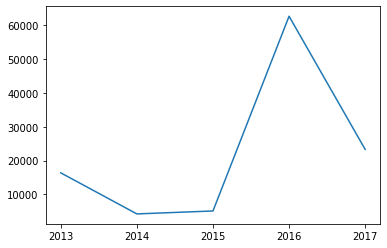

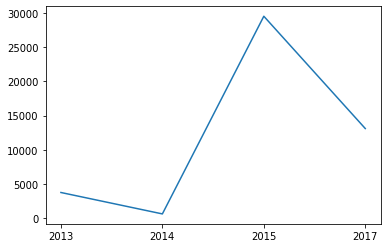

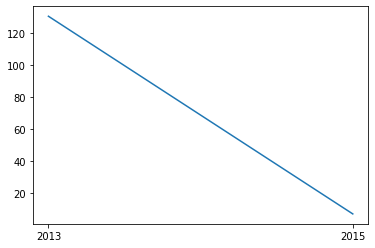

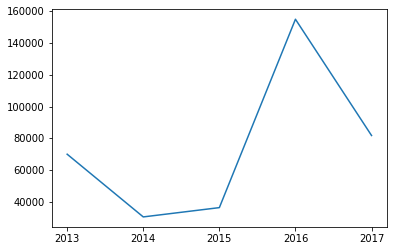

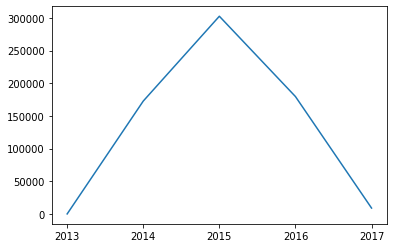

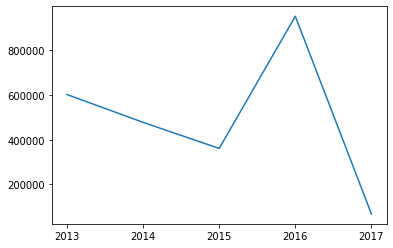

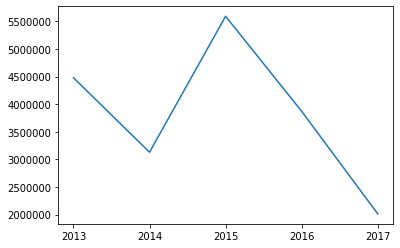

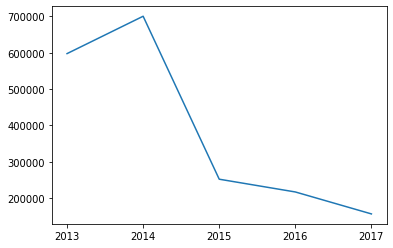

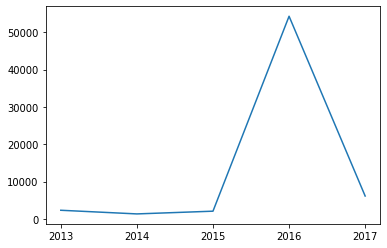

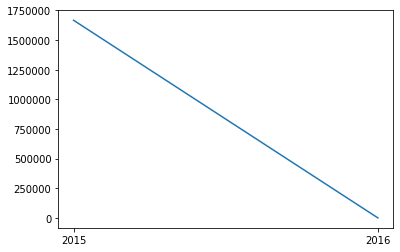

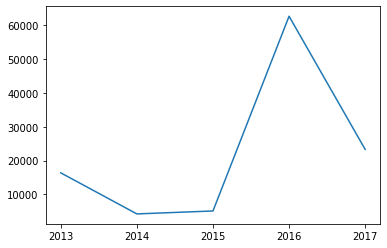

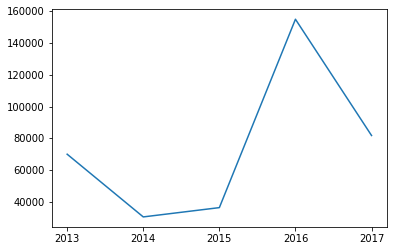

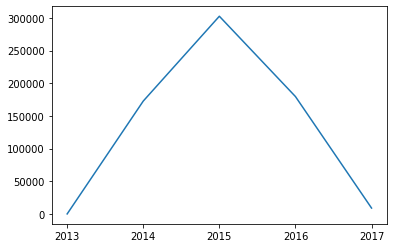

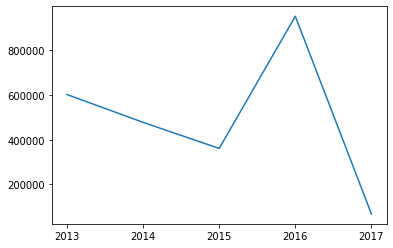

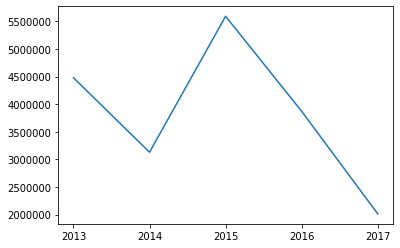

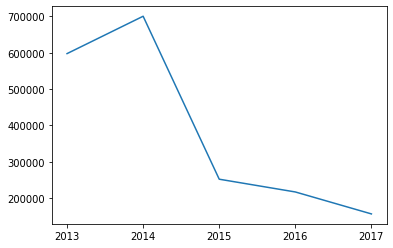

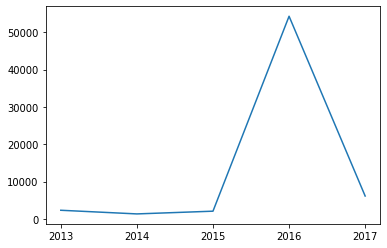

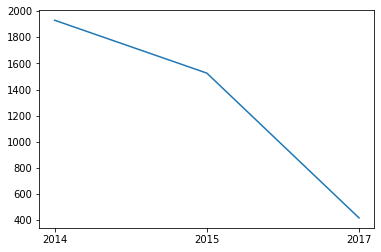

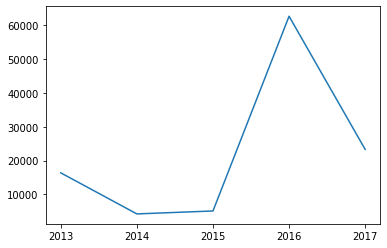

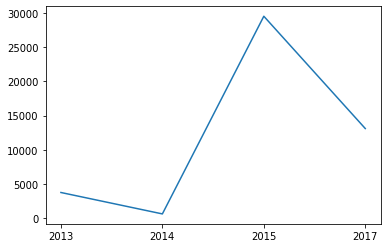

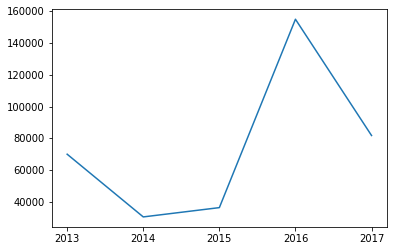

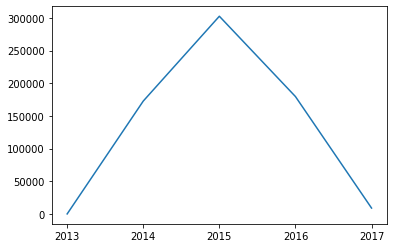

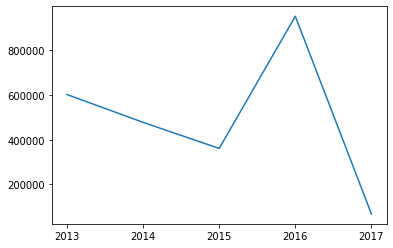

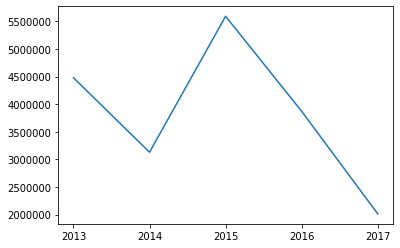

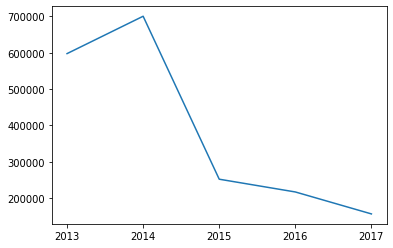

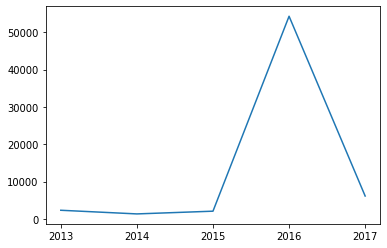

--------------------------------------------
Plotting for segment-
V
--------------------------------------------


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


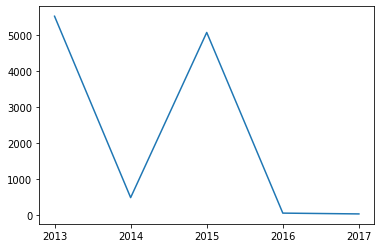

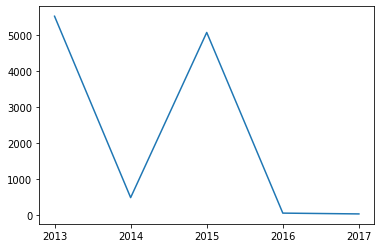

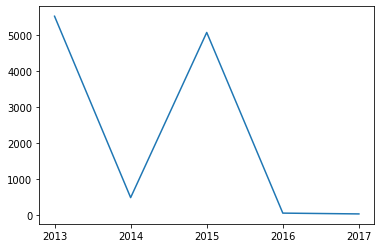

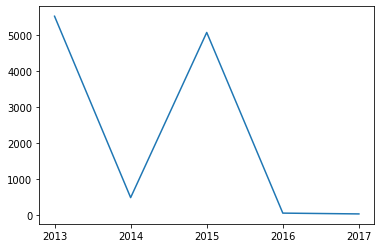

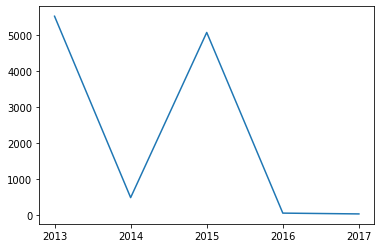

--------------------------------------------
Plotting for segment-
A
--------------------------------------------


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


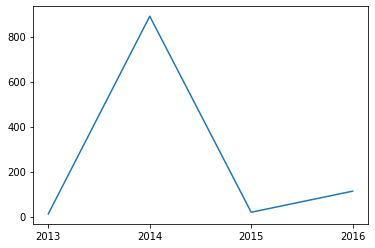

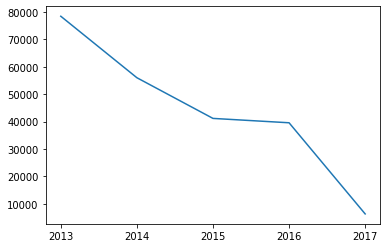

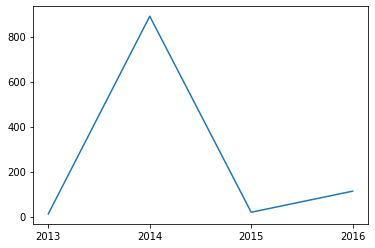

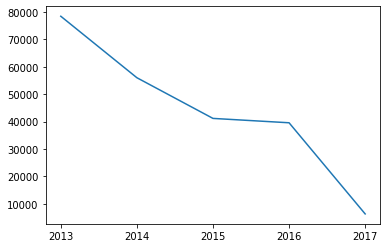

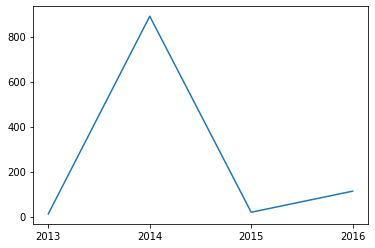

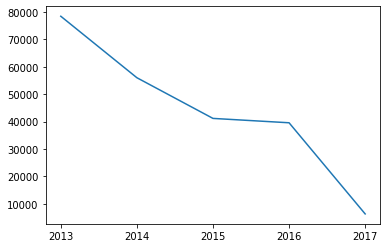

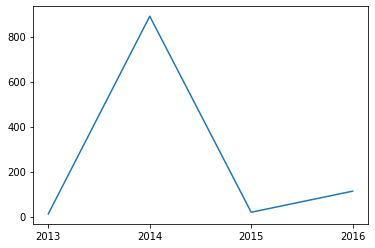

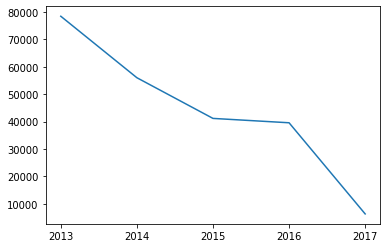

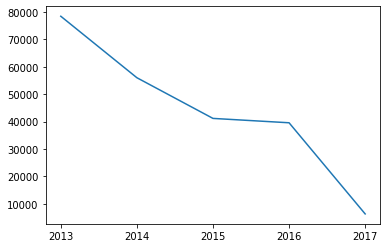

--------------------------------------------
Plotting for segment-
P
--------------------------------------------


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


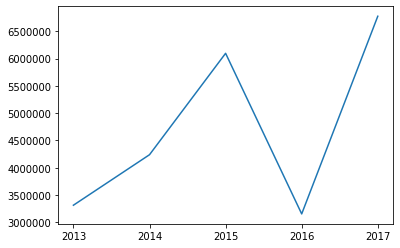

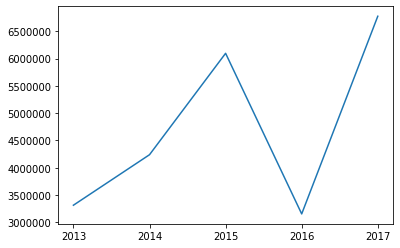

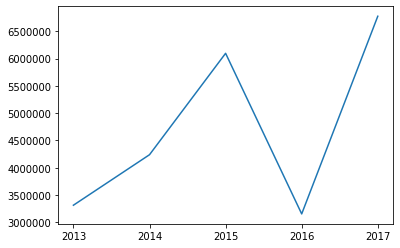

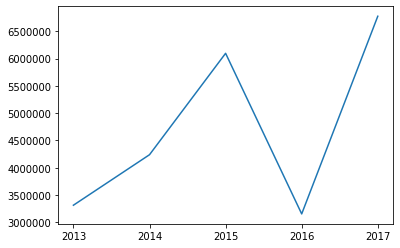

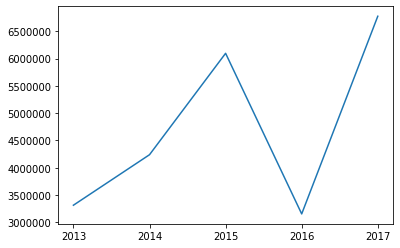

--------------------------------------------
Plotting for segment-
W
--------------------------------------------


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


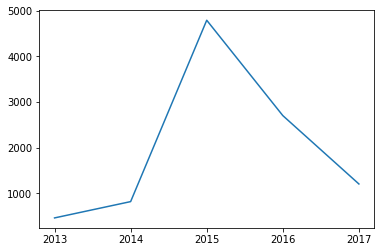

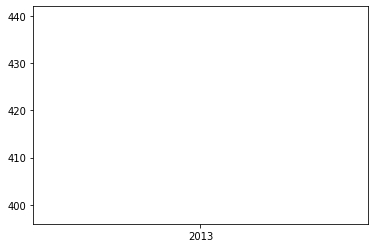

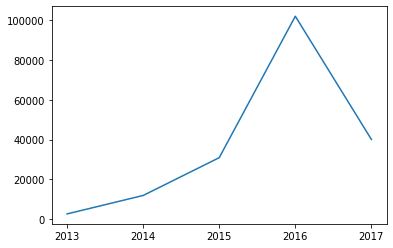

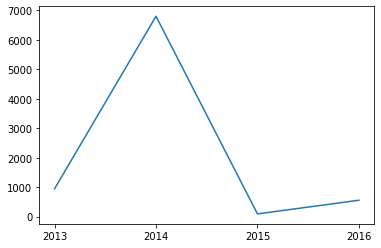

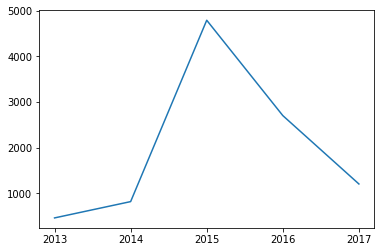

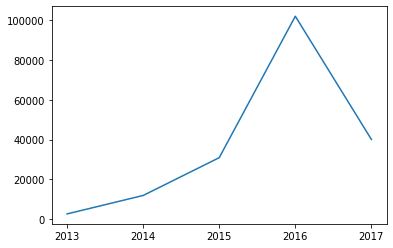

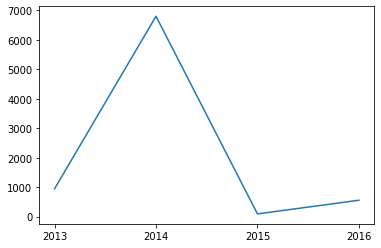

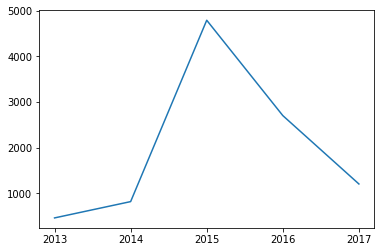

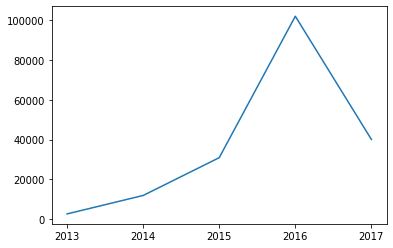

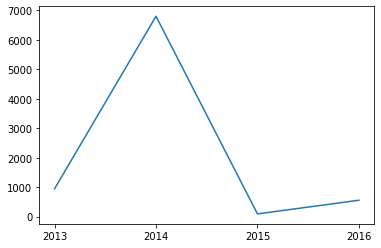

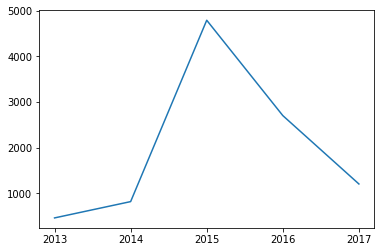

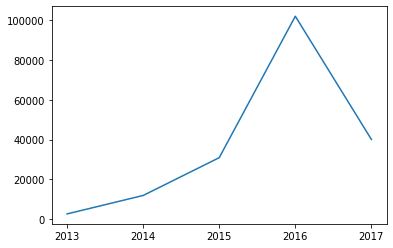

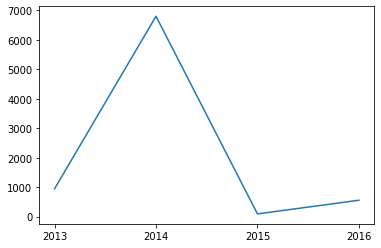

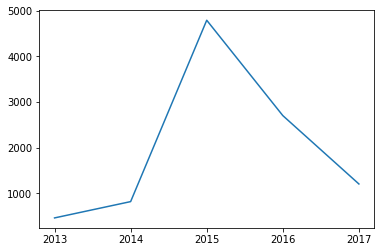

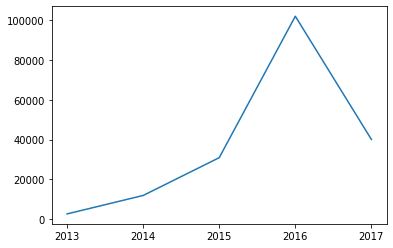

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


--------------------------------------------
Plotting for segment-
H
--------------------------------------------


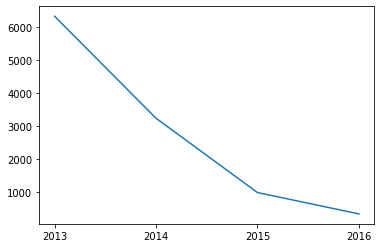

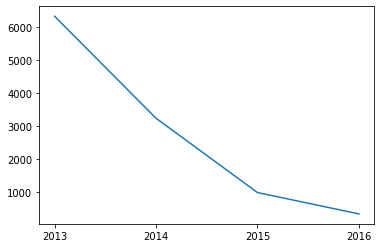

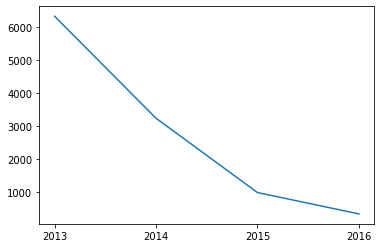

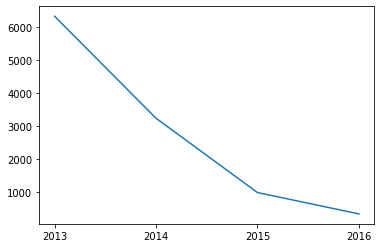

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


--------------------------------------------
Plotting for segment-
R
--------------------------------------------


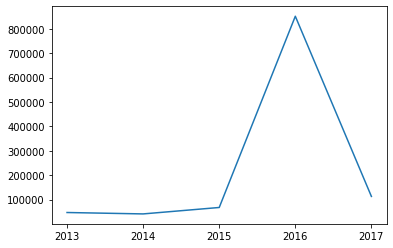

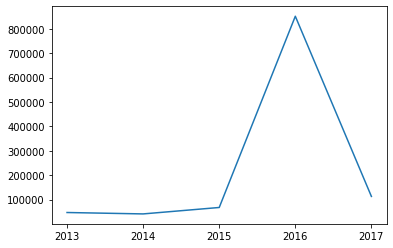

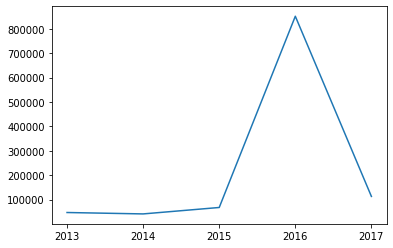

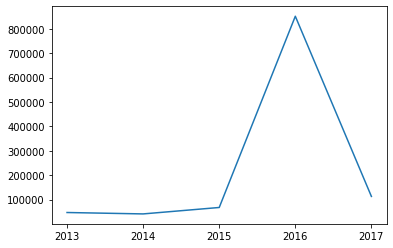

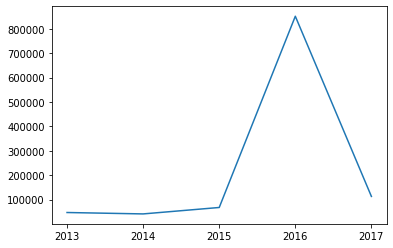

In [35]:
'''
Module to identify behaviour of segments.
Steps-
1. Identify the KPI's based on which the segments have
    been created.
'''

# Unique segments present in the data
segments = set()
for elems in trans_df['Customer Segment']:
    segments.add(elems)
segments = list(segments)

# Check total sales trend for each segments
for segs in segments:
    seg_df = pd.DataFrame(index = trans_df.index, columns = trans_columns)
    seg_df = seg_df.sort_values('Year')
    seg_df['total_amt'] = 0
    
    for i in range(1, len(trans_df)):
        if trans_df['Customer Segment'][i] == segs:
            seg_df.loc[i] = trans_df.loc[i]
    
    seg_df.dropna(subset = ['Customer Segment'], inplace = True)
    seg_df.reset_index(drop = True, inplace = True)

    for i in range(1, len(seg_df)):
        # Create total amount column by multiplying per unit cost.
        # with toatl orders.
        seg_df['total_amt'][i] = int(seg_df['Orders'][i]) * float(seg_df['Sales'][i])
    # Create new aggegate dataframe with pertinent columns.
    seg_agg_df = seg_df.groupby(['Year', 'CustomerID']).total_amt.sum().to_frame('Total_Sale').reset_index()
    
    print('--------------------------------------------')
    print('Plotting for segment-')
    print(segs)
    print('--------------------------------------------')
    # Plot to understand the trend
    for customers in seg_agg_df['CustomerID']:
        financial_year = []
        total_sale = []
        
        for i in range(0, len(seg_agg_df)):
            if seg_agg_df['CustomerID'][i] == customers:
                financial_year.append(seg_agg_df['Year'][i])
                total_sale.append(seg_agg_df['Total_Sale'][i])
        plot(financial_year, total_sale)
        show()

In [40]:
'''
Module to identify churn.
Steps-
1. Identify the KPI's based on which the segments have
    been created.
'''
churn_df = trans_df.copy()
churn_df = churn_df.sort_values('Year')
churn_df['total_amt'] = 0

for i in range(1, len(churn_df)):
    # Convert month value to integer.
    churn_df['Month'][i] = int(churn_df['Month'][i])
    # Create total amount column by multiplying per unit cost.
    # with toatl orders.
    churn_df['total_amt'][i] = int(churn_df['Orders'][i]) * float(churn_df['Sales'][i])

# Create new aggegate dataframe with pertinent columns.
churn_agg_df = churn_df.groupby(['Year', 'CustomerID', 'Supplier', 'SKU No']).total_amt.sum().to_frame('Total_Sale').reset_index()

# add composite key- concat(CustomerID, Supplier)
churn_agg_df['c_key'] = 'N/A'
for i in range(0, len(churn_agg_df)):
    churn_agg_df['c_key'][i] = churn_agg_df['CustomerID'][i] + churn_agg_df['Supplier'][i]
    
# creating the tagged dataframe
churn_tagged_df = pd.DataFrame(index=churn_agg_df.index, columns = ['customer_id', 'c_key', 'median', 'curr_year_percentage', 'tag'])
churn_tagged_df['tag'] = 'No Value'
idx = 0
for customers in churn_agg_df['CustomerID']:
    curr_year = 0
    percentage = []
    init_store = []
    for i in range(0, len(churn_agg_df)):
        if churn_agg_df['CustomerID'][i] == customers:
            init_store.append(churn_agg_df['Total_Sale'][i])
            churn_tagged_df['c_key'][i] = churn_agg_df['c_key'][i]
    
    # Calculate percentage increase or decrease.
    for i in range(1, len(init_store)):
        temp = ((init_store[i] - init_store[i - 1]) / init_store[i - 1]) * 100
        percentage.append(temp)
    
    ln = len(percentage) - 1
    if ln >= 0:
        curr_year = percentage[ln]
    # Drop the na values and reset index
    churn_tagged_df.dropna(subset=['c_key'], inplace = True)
    churn_tagged_df.reset_index(drop = True, inplace = True)
    # Calculate the kpi metrices.
    churn_tagged_df['customer_id'][idx] = customers
    churn_tagged_df['median'][idx] = median(percentage)
    churn_tagged_df['curr_year_percentage'][idx] = curr_year
    idx += 1
print(churn_tagged_df)
# Tag the customer ids based on anlysis
for i in range(0, len(churn_tagged_df)):
    if churn_tagged_df['median'][i] > 0 and churn_tagged_df['curr_year_percentage'][i] < 0:
        churn_tagged_df['tag'][i] = 'high focus'
    elif churn_tagged_df['median'][i] > 0 and churn_tagged_df['curr_year_percentage'][i] > 0 and churn_tagged_df['curr_year_percentage'][i] < churn_tagged_df['median'][i]:
        churn_tagged_df['tag'][i] = 'medium focus'
    elif churn_tagged_df['median'][i] < 0 and churn_tagged_df['curr_year_percentage'][i] > 0 and churn_tagged_df['curr_year_percentage'][i] > churn_tagged_df['median'][i]:
        churn_tagged_df['tag'][i] = 'keep track'
    else:
        churn_tagged_df['tag'][i] = 'safe'

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:41: Runt

KeyboardInterrupt: 

In [38]:
churn_agg_df

,Year,CustomerID,Supplier,SKU No,Total_Sale
0,2013,10,B&J,2053480,10
1,2013,10,BERKER,2028611,4
2,2013,10,BETTERMA,2006021,3
3,2013,10,BETTERMA,2025016,38
4,2013,10,DRAKA-M,5010585,24168
5,2013,10,ENERGIZE,2810885,2
6,2013,10,FRAENK.R,2687621,7572
7,2013,10,FRAENK.R,2687654,23130
8,2013,10,FRAENK.R,2687680,127
9,2013,10,FRAENK.R,2687681,17


In [39]:
trans_df

,id,Year,Customer Segment,Channel,CustomerID,Order No,Orders,Sales,SKU No,Supplier,Order Date,Month
1,1,2015,I,eCommerce,1,4291380,1,35.96,2007591,STRIEBEL,20150714,7\n
2,2,2015,I,eCommerce,1,4367314,600,90.9,1122056,KAB+LTG,20150801,8\n
3,3,2015,I,eCommerce,1,4241772,9,146.79,2396689,HARTING,20150703,7\n
4,4,2015,I,eCommerce,1,4234907,4,29.36,2396870,HARTING,20150702,7\n
5,5,2015,I,eCommerce,1,4367314,400,369.54,1122130,KAB+LTG,20150801,8\n
6,6,2015,I,eCommerce,1,4456675,600,50.38,1001096,KAB+LTG,20150817,8\n
7,7,2015,I,eCommerce,1,4234907,50,209,2396805,HARTING,20150702,7\n
8,8,2015,I,eCommerce,1,4367314,500,46.71,1122029,KAB+LTG,20150801,8\n
9,9,2015,I,eCommerce,1,4367314,300,108.3,1122101,KAB+LTG,20150801,8\n
10,10,2015,I,eCommerce,1,4367314,2000,186.84,1122026,KAB+LTG,20150801,8\n
